In [1]:
import pandas as pd
pd.set_option('display.max_column', 250)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
from matplotlib import rcParams
rcParams['figure.figsize'] = (6, 4)
rcParams['figure.dpi'] = 150

from tqdm import tnrange, tqdm_notebook

import sys
sys.path.append('/content/gdrive')

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Formulas

In [2]:
def read_arff(path):
    import arff
    data = arff.load(open(path))
    cnames = [i[0] for i in data['attributes']]
    df = pd.DataFrame(data['data'], columns=cnames)
    return df

def preprocess(DataFrame):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    le = LabelEncoder()
    y = le.fit_transform(y)
    from sklearn.model_selection import train_test_split
    return X, y

In [3]:
def prequential(n_init_tr, model, X, y, w):
    y_pred = []
    
    row_n = y.shape[0]

    for i in tnrange(row_n - n_init_tr):
        Xn = X.iloc[:n_init_tr+i,:]
        yn = y[:n_init_tr+i]
        if w>(n_init_tr+i):
            model.fit(Xn, yn)
            y_pred.append(model.predict(X.iloc[n_init_tr+i,:].values.reshape(1,-1)))
        else:
            model.fit(Xn.iloc[-w:,:], yn[-w:])
            y_pred.append(model.predict(X.iloc[n_init_tr+i,:].values.reshape(1,-1)))
        
    pred_match = np.equal(np.array(y_pred).reshape(1,-1), y[n_init_tr:].reshape(1,-1))
    accuracy = np.cumsum(pred_match)/np.arange(1, pred_match.shape[1]+1)
    # returns average accuracy, predicted y and true y
    return accuracy, np.array(y_pred).reshape(1,-1), y[n_init_tr:].reshape(1,-1)

In [4]:
def plot_acc(avg_acc, y_pred, y_true, model_name):
    
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    try:
        print(
            "Average Accuracy: {:.2f}%\n".format(avg_acc.mean()*100),
            "Precision Score: {:.2f}%\n".format(precision_score(y_true, y_pred, average='samples')*100),
            "Recall Score: {:.2f}%\n".format(recall_score(y_true, y_pred, average='samples')*100),
            "F1-Score: {:.2f}%\n".format(f1_score(y_true, y_pred, average='samples')*100)
        )
    except:
        pass
    
    pd.DataFrame({'acc': avg_acc, 'ypred': y_pred[0], 'ytrue': y_true[0]}).to_csv(file_path[:-4]+model_name+'.csv')

    plt.plot(avg_acc)
    plt.ylim(0.4)
    plt.xlabel('Iterations')
    plt.ylabel('Average Accuracy')
    plt.title(model_name + ' Average Accuracy')
    plt.show()

In [5]:
file_path = '../../data/RBF.arff'
df = read_arff(file_path)
X, y = preprocess(df)

## Naive Bayes

In [6]:
nb_acc, nb_ypred, nb_ytrue = prequential(1000, GaussianNB(), X, y, 5000)

Average Accuracy: 54.60%
 Precision Score: 53.98%
 Recall Score: 63.78%
 F1-Score: 58.47%



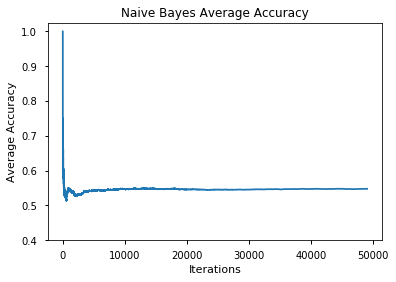

In [7]:
plot_acc(nb_acc, nb_ypred, nb_ytrue, "Naive Bayes")

##  Logistic Regression

In [8]:
lr_acc, lr_ypred, lr_ytrue = prequential(1000, LogisticRegression(solver='sag'), X, y, 5000)

Average Accuracy: 53.90%
 Precision Score: 54.12%
 Recall Score: 53.23%
 F1-Score: 53.67%



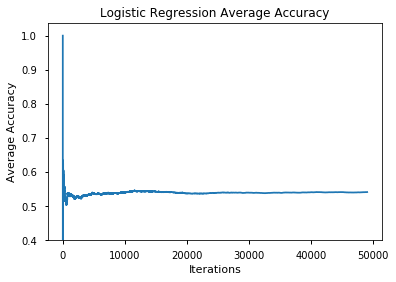

In [9]:
plot_acc(lr_acc, lr_ypred, lr_ytrue, 'Logistic Regression')

## KNN

In [10]:
knn_acc, knn_ypred, knn_ytrue = prequential(1000, KNeighborsClassifier(n_neighbors=100), X, y, 5000)

Average Accuracy: 56.66%
 Precision Score: 55.99%
 Recall Score: 65.58%
 F1-Score: 60.41%



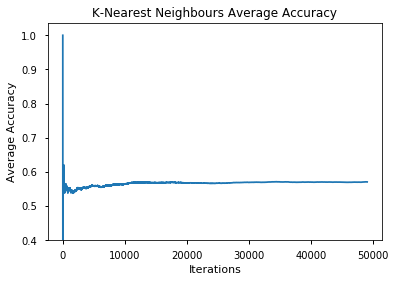

In [11]:
plot_acc(knn_acc, knn_ypred, knn_ytrue, 'K-Nearest Neighbours')

## Decision Tree

In [12]:
dt_acc, dt_ypred, dt_ytrue = prequential(1000, DecisionTreeClassifier(), X, y, 5000)

Average Accuracy: 54.54%
 Precision Score: 54.96%
 Recall Score: 54.71%
 F1-Score: 54.83%



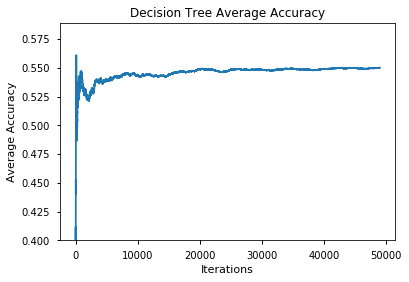

In [13]:
plot_acc(dt_acc, dt_ypred, dt_ytrue, 'Decision Tree')

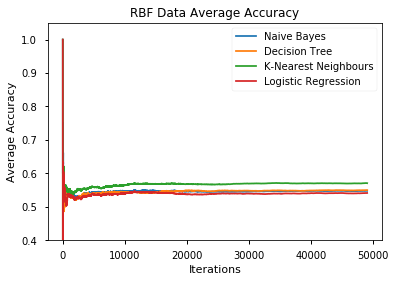

In [14]:
plt.plot(nb_acc, label='Naive Bayes')
plt.plot(dt_acc, label='Decision Tree')
plt.plot(knn_acc, label='K-Nearest Neighbours')
plt.plot(lr_acc, label='Logistic Regression')
plt.ylim(0.4)
plt.xlabel('Iterations')
plt.ylabel('Average Accuracy')
plt.title(file_path[9:-5]+' Data Average Accuracy')
plt.legend()
plt.savefig(file_path[:-5], dpi=300)
plt.show()